# Florida

## Part 1

### Data load & Data exploration

In [27]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [28]:
data = pd.read_csv('./nytimes-covid-data/us-states.csv')

In [29]:
florida_data = data[data['state']=='Florida'].copy(deep=True).reset_index(drop=True)

In [30]:
florida_data.head()

,date,state,fips,cases,deaths
0,2020-03-01,Florida,12,2,0
1,2020-03-02,Florida,12,2,0
2,2020-03-03,Florida,12,3,0
3,2020-03-04,Florida,12,3,0
4,2020-03-05,Florida,12,4,0


In [31]:
florida_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764 entries, 0 to 763
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    764 non-null    object
 1   state   764 non-null    object
 2   fips    764 non-null    int64 
 3   cases   764 non-null    int64 
 4   deaths  764 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 30.0+ KB


In [32]:
florida_data['date'] = pd.to_datetime(florida_data['date'])

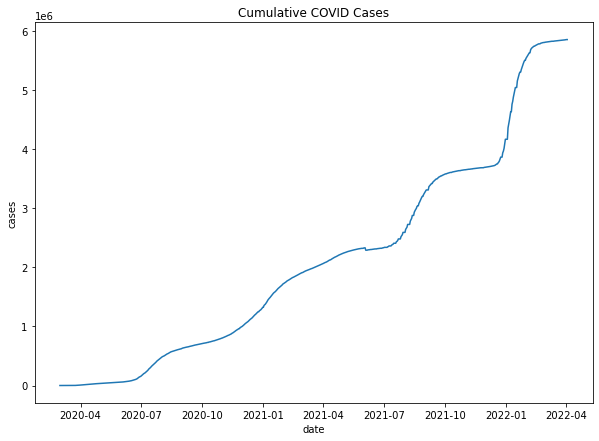

In [33]:
fig, ax = plt.subplots(figsize=(10, 7))

p = sns.lineplot(x='date', y='cases', data=florida_data)
p.set(title="Cumulative COVID Cases")
plt.show()

In [34]:
fl_dates = florida_data['date'].to_numpy()
fl_total_cases = florida_data['cases'].to_numpy()
fl_new_cases = np.zeros(fl_total_cases.shape)

for i in range(len(fl_total_cases)):
    if i == 0:
        fl_new_cases[i] = fl_total_cases[i]
    else:
        fl_new_cases[i] = fl_total_cases[i] - fl_total_cases[i-1]

fl_infected = np.zeros(fl_total_cases.shape)
fl_recovered = np.zeros(fl_total_cases.shape)

for i in range(len(fl_total_cases)):
    if i >= 13:
        recovered = sum(fl_new_cases[:i-13])
    else:
        recovered = 0
        
    fl_infected[i] = fl_total_cases[i] - recovered
    fl_recovered[i] = recovered

## Set Input Parameters

In [36]:
### Parameters to Vary ###

# lambda: number of people that a susceptible person interacts with per time step
# p: probability of getting infected if a susceptible person interacts with an infectious person
# gamma: recovery rate (recovery probability within one time step)
lam, p, gamma = 3, 0.05, 1./14 # set lam = 2 vs 20, p = 0.3, gamma = 1/14

# probability of getting infected every time step
#beta = 1 - pow(1-p,lam)
beta = min(1, lam * p) # beta <= 1 by definition

In [51]:
### Fixed Parameters ###

# Total population. (Florida 2020)
N_total = 21538187

# Some vaccinated people are immune
N = N_total

# A grid of time points (in days) for the detecting period
t = np.linspace(0, len(fl_dates)-1, len(fl_dates))

# Initial number of infected and immune individuals, I0 and R0.
I0, R0 = 2, 0

# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

# Initial conditions vector
y0 = S0, I0, R0

## Time-Dependent R_0

In [52]:
# The SIR model differential equations.
def deriv_dynamic(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta(t) * S * I / N
    dIdt = beta(t) * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [53]:
def R_0_dynamic(t):
    value = None
    for i in range(len(epochs)):
        if t >= epochs[i]:
            value = logistic_R_0(t, k[i], x[i], R_0[i],  R_0[i+1])
    return value

def logistic_R_0(t, k, x, start, end):
    return (start - end) / (1 + np.exp(-k * (-t + x))) + end

def beta_dynamic(t):
    return R_0_dynamic(t) * gamma

In [54]:
def abse(pred, true):
    sum = 0
    for i in range(len(true)):
        sum += abs(true[i] - pred[i]) 
    
    return sum / len(true)

def rmse(pred, true):
    sum = 0
    for i in range(len(true)):
        sum += math.pow(true[i] - pred[i], 2)
    
    return math.sqrt(sum / len(true))

$$R_0(t) = \frac{R_0^{start} - R_0^{end}}{1 + e^{-k(-x+x_0)}} + R_0^{end}$$

<br>
<br>
Here R_0^{start} and R_0^{end} are the starting and ending $R_0$ values that we want to interpolate between. 

$x_0$ is the inflection point of the transition, i.e., the day that $R_0$ changes most dramatically. You can interpret is the main lockdown day.

$k$ describes how fast R_0 change. Larger $k$ means faster change.

## MAE

In [491]:
# Define epoch start dates
epochs = [0, 77, 145, 210, 320, 480, 540, 658]

# R0 values for each epoch
R_0 = [2.7, 1.69, 0.72, 1.27, 0.91, 1.85, 0.55, 4.33, 0.23]

# k and x values for smooth R0 transition function
k = [0.15, 0.07, 0.08, 0.09, 0.5, 0.5, 0.3, 0.38]
x = [60, 175, 265, 343, 480, 576, 650, 680]


ret = odeint(deriv_dynamic, y0, t, args = (N, beta_dynamic, gamma))
S, I, R = ret.T

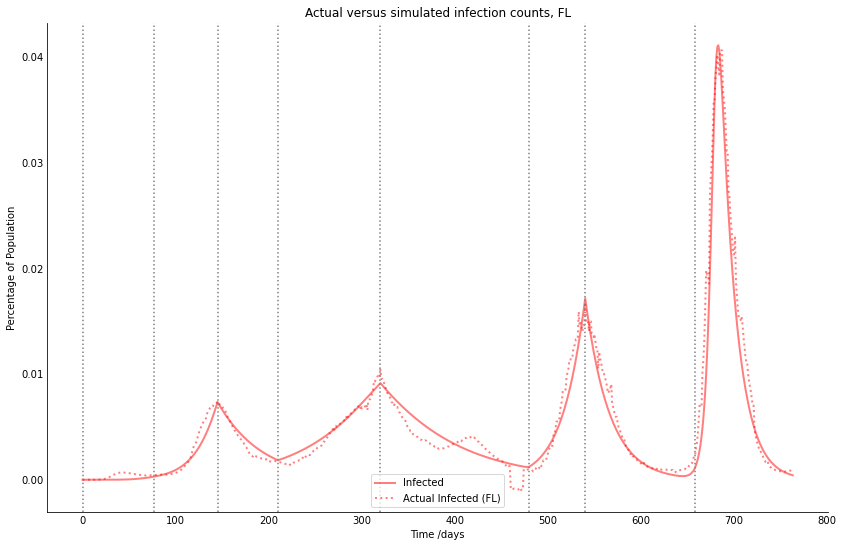

In [492]:
# Plot the data on predicted and actual infections 

fig, ax = plt.subplots(facecolor='w', figsize = (14, 9))

ax.plot(t, I/N_total, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, fl_infected/N_total, 'r:', alpha=0.5, lw=2, label='Actual Infected (FL)')
ax.set_xlabel('Time /days')
ax.set_ylabel('Percentage of Population')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')

for e in epochs:
    plt.axvline(x=e, color="grey", linestyle=':')
legend = ax.legend()
legend.get_frame().set_alpha(0.75)
for spine in ('top', 'right'):#, 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
    
plt.title("Actual versus simulated infection counts, FL")
plt.show()

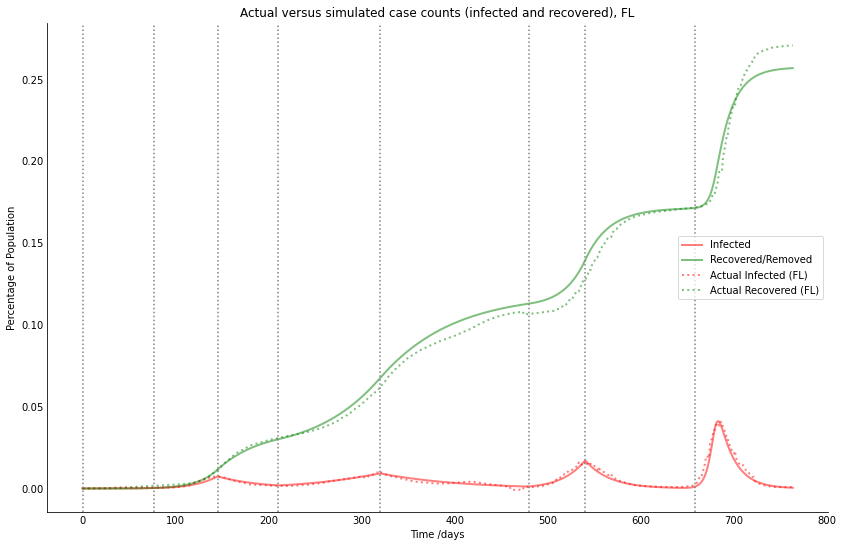

In [493]:
# Plot the data for predicted and actual infections and recoveries

fig, ax = plt.subplots(facecolor='w', figsize = (14, 9))

ax.plot(t, I/N_total, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/N_total, 'g', alpha=0.5, lw=2, label='Recovered/Removed')
ax.plot(t, fl_infected/N_total, 'r:', alpha=0.5, lw=2, label='Actual Infected (FL)')
ax.plot(t, fl_recovered/N_total, 'g:', alpha=0.5, lw=2, label='Actual Recovered (FL)')
ax.set_xlabel('Time /days')
ax.set_ylabel('Percentage of Population')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')

for e in epochs:
    plt.axvline(x=e, color="grey", linestyle=':')
legend = ax.legend()
legend.get_frame().set_alpha(0.75)
for spine in ('top', 'right'):#, 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
    
plt.title("Actual versus simulated case counts (infected and recovered), FL")
plt.show()

In [494]:
print(f"Abolute Error: {mean_absolute_error(fl_infected, I)}")

Abolute Error: 19021.325262988077


## RMSE

In [495]:
#########################################
#Tuning parameters######################

# Define epoch start dates
epochs = [0, 77, 145, 210, 320, 480, 540, 658]

# R0 values for each epoch
R_0 = [2.7, 1.69, 0.72, 1.27, 0.91, 1.85, 0.55, 4.33, 0.23]

# k and x values for smooth R0 transition function
k = [0.15, 0.07, 0.08, 0.09, 0.5, 0.5, 0.3, 0.38]
x = [60, 175, 265, 343, 480, 576, 650, 680]


ret = odeint(deriv_dynamic, y0, t, args = (N, beta_dynamic, gamma))
S, I, R = ret.T

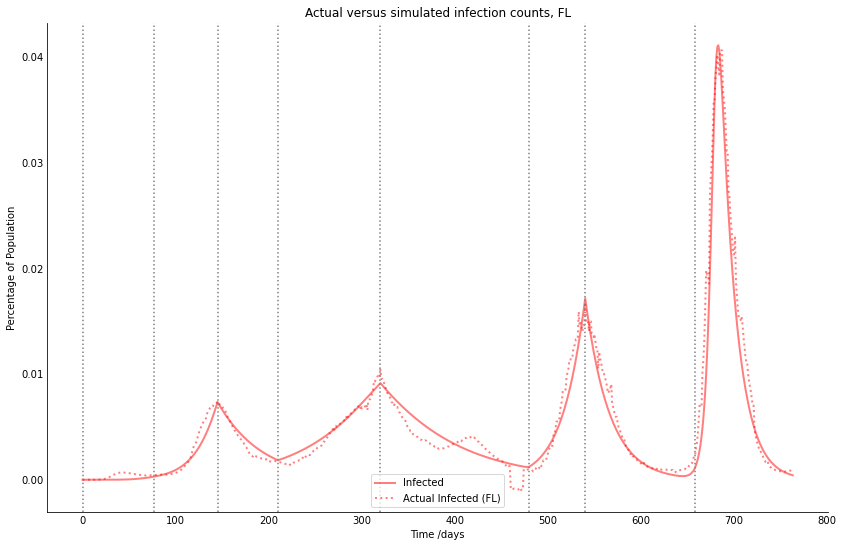

In [496]:
# Plot the data on predicted and actual infections 

fig, ax = plt.subplots(facecolor='w', figsize = (14, 9))

ax.plot(t, I/N_total, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, fl_infected/N_total, 'r:', alpha=0.5, lw=2, label='Actual Infected (FL)')
ax.set_xlabel('Time /days')
ax.set_ylabel('Percentage of Population')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')

for e in epochs:
    plt.axvline(x=e, color="grey", linestyle=':')
legend = ax.legend()
legend.get_frame().set_alpha(0.75)
for spine in ('top', 'right'):#, 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
    
plt.title("Actual versus simulated infection counts, FL")
plt.show()

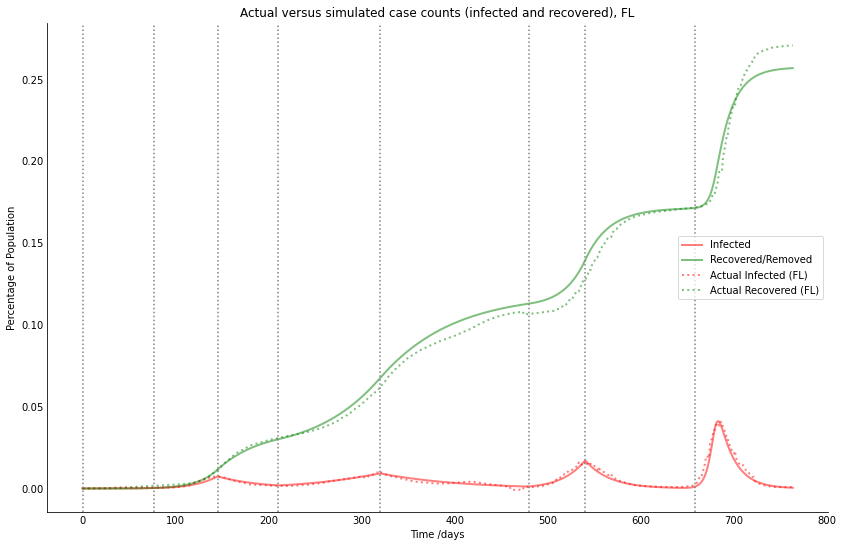

In [497]:
# Plot the data for predicted and actual infections and recoveries

fig, ax = plt.subplots(facecolor='w', figsize = (14, 9))

ax.plot(t, I/N_total, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/N_total, 'g', alpha=0.5, lw=2, label='Recovered/Removed')
ax.plot(t, fl_infected/N_total, 'r:', alpha=0.5, lw=2, label='Actual Infected (FL)')
ax.plot(t, fl_recovered/N_total, 'g:', alpha=0.5, lw=2, label='Actual Recovered (FL)')
ax.set_xlabel('Time /days')
ax.set_ylabel('Percentage of Population')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')

for e in epochs:
    plt.axvline(x=e, color="grey", linestyle=':')
legend = ax.legend()
legend.get_frame().set_alpha(0.75)
for spine in ('top', 'right'):#, 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
    
plt.title("Actual versus simulated case counts (infected and recovered), FL")
plt.show()

In [498]:
print(f"RMSE: {mean_squared_error(fl_infected, I, squared=False)}")

RMSE: 29791.32725277255
